In [4]:
!pip install tensorflow-addons==0.9.1
!pip install tqdm 

     |████████████████████████████████| 1.0 MB 15.0 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%load_ext tensorboard

import functools
from glob import glob
import os


import numpy as np
import random
import tqdm


import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as display
import PIL
from PIL import Image
import imageio

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import sys
sys.path.insert(0,'/content/drive/My Drive/cycleGAN')  # path of the project
from experiment_utils import *

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Kaggle에서 데이터 불러오기

In [2]:
 ! pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ssdsdssdf","key":"217fa84f8568f8e73676739b8899e0fe"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets download -d suyashdamle/cyclegan

100% 3.39G/3.40G [00:50<00:00, 72.7MB/s]
100% 3.40G/3.40G [00:50<00:00, 72.9MB/s]


In [ ]:
! mkdir data_cycleGAN
! unzip cyclegan.zip -d data_cycleGAN

## Configs

In [9]:
# Experiment paths
output_dir = "/content/drive/My Drive/cycleGAN/train_results"
checkpoint_name = "checkpoint_test"
checkpoint_path = os.path.join(output_dir, checkpoint_name)
sample_dir = os.path.join(output_dir, 'samples_training')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
train_summary_writer = tf.summary.create_file_writer(os.path.join(output_dir, 'summaries', 'train'))

# Data Paths
DATA_PATH_DOMAIN_A_TRAIN = '/content/data_cycleGAN/facades/facades/trainA/*.jpg'
DATA_PATH_DOMAIN_B_TRAIN = '/content/data_cycleGAN/facades/facades/trainB/*.jpg'
DATA_PATH_DOMAIN_A_TEST = '/content/data_cycleGAN/facades/facades/testA/*.jpg'
DATA_PATH_DOMAIN_B_TEST = '/content/data_cycleGAN/facades/facades/testB/*.jpg'

# Model Hyperparameter
input_shape = (128, 128, 3)
hidden_layers = 3
BATCH_SIZE = 1
LR = 0.0002
BETA_1 = 0.5
epoch_decay = 100
epochs = 125
cycle_loss_weight = 10.0
identity_loss_weight = 0.0
gradient_penalty_weight = 10.0
gradient_penalty_mode = 'none'

ep_cnt = tf.Variable(initial_value=0, trainable=False, dtype=tf.int64)
seed = random.seed(30)

## Data 

In [10]:
def get_paths_domain(path):
    img_paths = []
    for filename in glob(path):
        img_paths.append(filename)
    return list(img_paths)

In [11]:
domainA_img_paths = get_paths_domain(DATA_PATH_DOMAIN_A_TRAIN)
domainB_img_paths = get_paths_domain(DATA_PATH_DOMAIN_B_TRAIN)

domainA_img_paths_test = get_paths_domain(DATA_PATH_DOMAIN_A_TEST)
domainB_img_paths_test = get_paths_domain(DATA_PATH_DOMAIN_B_TEST)

In [12]:
A_image_size = []
for filename in domainA_img_paths:
    im=Image.open(filename)
    im =im.size
    A_image_size.append(im)
print(max(A_image_size))
print(min(A_image_size))

(256, 256)
(256, 256)


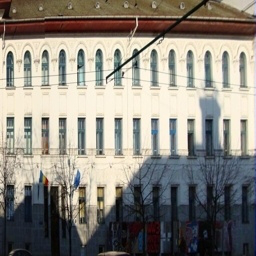

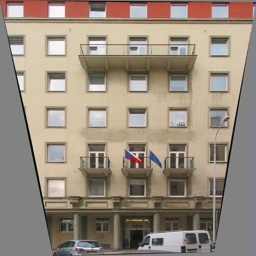

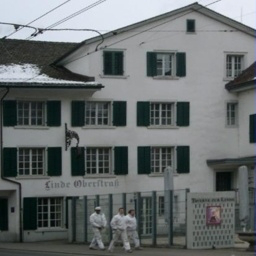

In [13]:
for image_path in domainA_img_paths[:3]:
    display.display(Image.open(str(image_path)))

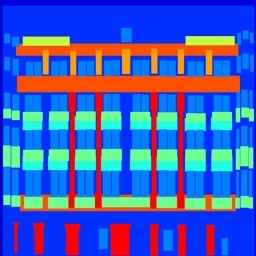

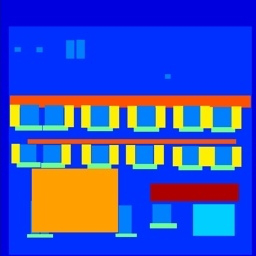

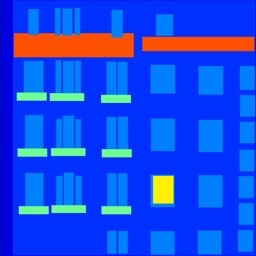

In [14]:
for image_path in domainB_img_paths[:3]:
    display.display(Image.open(str(image_path)))

In [15]:
B_image_size = []
for filename in domainB_img_paths:
    im=Image.open(filename)
    im =im.size
    B_image_size.append(im)
print(max(B_image_size))
print(min(B_image_size))

(256, 256)
(256, 256)


## Data Loader

In [16]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [128, 128])
    image = (image -127.0) / 127.0
    return image

In [17]:
def dataloader(paths, mode="train"):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    if mode == "train":
        dataset = dataset.shuffle(buffer_size=len(paths))  # 학습 데이터는 랜덤하게 섞음
    dataset = dataset.map(preprocessing_data, num_parallel_calls=4)
    if mode == "test":
        dataset = dataset.repeat(BATCH_SIZE * epochs)  # multiple epochs에서 데이터셋을 반복
    dataset = dataset.batch(BATCH_SIZE)  # 1 batch당 BATCH_SIZE개의 이미지
    dataset = dataset.prefetch(1)
    return dataset

`tf.data.Dataset.from_tensor_slices` : tf.data.Dataset을 생성. 입력된 텐서로부터 slices를 생성  

    * ex) (60000, 28, 28) 학습 데이터에를 60000개의 slices로 만들고 각각의 slice는 28 x 28 크기의 이미지를 가짐

`tf.data` 참고 : https://hwiyong.tistory.com/332

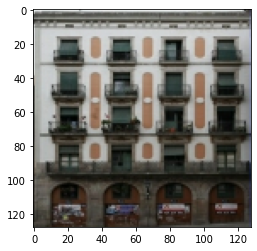

In [18]:
data_test = dataloader(domainA_img_paths)
for batch in data_test.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

In [19]:
def zip_data(domainA_paths, domainB_paths, mode="train"):
    A_dataset = dataloader(domainA_paths, mode)
    B_dataset = dataloader(domainB_paths, mode)
    A_B_dataset = tf.data.Dataset.zip((A_dataset, B_dataset))
    len_dataset = max(len(domainA_paths), len(domainB_paths)) // BATCH_SIZE
    return A_B_dataset, len_dataset

In [20]:
A_B_dataset, len_dataset = zip_data(domainA_img_paths, domainB_img_paths)
A_B_dataset_test, _ = zip_data(domainA_img_paths_test, domainB_img_paths_test, mode="test")

## Model


![image](https://user-images.githubusercontent.com/44194558/139825428-109f00e7-e364-4f16-8512-ab97688938ce.png)

<br/>

**판별자** : D_A, D_B

**생성자** : G_AB, G_BA

### Generator

생성자는 4개의 parts로 구성

**1. Encoder (Convolutional block)**

  -  Every convolution layer prompts the extraction of dynamically more elevated level highlights

**2. Residual block**

  - 결과물이 가지는 독특한 특성이 사라지지 않도록 함. 이전 레이어의 주요한 속성이 이후 레이어에 엑세스 할 수 있도록하여 원본 이미지의 특징 출력을 잘 유지할 수 있도록 함. (갑작스러운 변화를 방지)

  - This is done to guarantee properties of the contribution of past layers are accessible for later layers also with the goal that their yield doesn’t digress much from unique information, otherwise the characteristics of original images will not be retained in the output and results will be very abrupt. 

![image](https://user-images.githubusercontent.com/44194558/139826091-421df100-fff8-4597-b80b-ece9c5888519.png)


3. Decoder (Transpose block)

4. The final convolutional layer

- 이미지 정보들의 representation을 이미지로 변환

In [21]:
def residual_block(x):
    res_block = x
    res_block = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(res_block)
    res_block = layers.BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res_block)
    res_block = layers.Activation('relu')(res_block)
    res_block = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same")(res_block)
    res_block = layers.BatchNormalization(axis=3, momentum=0.9, epsilon=1e-5)(res_block)

    return layers.add([x, res_block])  # x + F(x) 

In [22]:
def generator(input_shape):
    input_layer = layers.Input(shape=input_shape)

    # Encoding
    layer = layers.Conv2D(filters=32, kernel_size=7, strides=1, padding="same")(input_layer)
    layer = tfa.layers.InstanceNormalization(axis=1)(layer)
    layer = layers.Activation("relu")(layer)

    layer = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(layer)
    layer = tfa.layers.InstanceNormalization(axis=1)(layer)
    layer = layers.Activation("relu")(layer)

    layer = layers.Conv2D(filters=128, kernel_size=3, strides=2, padding="same")(layer)
    layer = tfa.layers.InstanceNormalization(axis=1)(layer)
    layer = layers.Activation("relu")(layer)

    # Residual blocks (논문에서 6개 사용)
    for _ in range(6): 
        layer = residual_block(layer)

    # Decoder
    layer = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False)(layer)
    layer = tfa.layers.InstanceNormalization(axis=1)(layer)
    layer = layers.Activation("relu")(layer)
    
    layer = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', use_bias=False)(layer)
    layer = tfa.layers.InstanceNormalization(axis=1)(layer)
    layer = layers.Activation("relu")(layer)

    # Last Convolution layer
    layer = layers.Conv2D(filters=3, kernel_size=7, strides=1, padding="same")(layer)
    output = layers.Activation('tanh')(layer)

    return keras.Model(inputs=input_layer, outputs=output)

In [23]:
make_generator = generator([128, 128, 3])
make_generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 4736        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 128, 128, 32) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

## Discriminator

분류에 도움이 되는 이미지의 특징들을 더 깊이 파악하기 위해 생성자보다 많은 convolutional layer를 가짐. convolutional의 채널이 특성 변수의 역할을 수행하기 때문에 채널은 증가시키고 픽셀의 크기는 줄여 실제적인 특성 변수의 수를 증가시키는 효과를 볼 수 있도록 설계함.

이미지에 대한 각 n x n patch가 진짜/가짜 여부를 판별하는 CNN으로, 이미지에 convolutional하게 작동하여 모든 응답을 평균한 후 최종 아웃풋을 출력. pathGAN의 판별자와 유사한 측면이 있음.

  `ex) 판별자의 출력이 (2, 2, 1)의 3D 텐서 : 각 영역별로 MSE를 구해 4개 영역의 평균 MSE로 손실을 정의`

In [24]:
def discriminator(input_shape):
    input_layer = layers.Input(shape=input_shape)
    x = layers.ZeroPadding2D(padding=(1, 1))(input_layer)

    # 1st Convolutional block
    x = layers.Conv2D(filters=64, kernel_size=4, strides=2, padding="valid")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)  

    # 3 Hidden Convolution blocks
    for i in range(1, hidden_layers + 1):
        x = layers.Conv2D(filters=2 ** i * 64, kernel_size=4, strides=2, padding="valid")(x)
        x = tfa.layers.InstanceNormalization(axis=1)(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        x = layers.ZeroPadding2D(padding=(1, 1))(x)

    # Last Convolution layer
    output = layers.Conv2D(filters=1, kernel_size=4, strides=1, activation="sigmoid")(x)
    
    return keras.Model(inputs=[input_layer], outputs=[output])

In [25]:
make_discriminator = discriminator(input_shape)
make_discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       131200    
_________________________________________________________________
instance_normalization_5 (In (None, 32, 32, 128)       64  

In [26]:
G_A2B = generator(input_shape=(128, 128, 3))  # A -> B
G_B2A = generator(input_shape=(128, 128, 3))  # B -> A

D_A = discriminator(input_shape=(128, 128, 3))
D_B = discriminator(input_shape=(128, 128, 3))

## Loss

* CyclecConsistency loss
 - 이상적으로 원본 이미지 a와 재구성된 이미지 a_hat은 동일해야 함 (픽셀 수준에서 MAE를 활용하여 손실을 측정)

* Adversarial loss
 - 변환된 이미지가 진짜 같도록

* Identity loss 
 - 사진의 전반적인 색조가 원본 이미지와 일치하도록 규제항을 도입. 도입하지 않을 경우 변환된 이미지가 원본 이미지에 비해 색조가 크게 달라질 수 있음

In [27]:
def get_lsgan_losses_fn():
    mse = tf.losses.MeanSquaredError()

    def d_loss_fn(r_logit, f_logit):
        r_loss = mse(tf.ones_like(r_logit), r_logit)  # 진짜(1) 이미지를 진짜로 판별하도록
        f_loss = mse(tf.zeros_like(f_logit), f_logit)  # 가짜(0) 이미지를 가짜로 판별하도록
        return r_loss, f_loss

    def g_loss_fn(f_logit):
        f_loss = mse(tf.ones_like(f_logit), f_logit)  # 가짜 이미지를 진짜(1)라고 속이도록
        return f_loss

    return d_loss_fn, g_loss_fn

In [28]:
d_loss_fn, g_loss_fn = get_lsgan_losses_fn()  # Adversarial loss
cycle_loss_fn = tf.losses.MeanAbsoluteError()  # Cycle consistency loss
identity_loss_fn = tf.losses.MeanAbsoluteError()  # Identity loss

In [29]:
def gradient_penalty(f, real, fake, mode):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp

    if mode == 'none':
        gp = tf.constant(0, dtype=real.dtype)
    elif mode == 'dragan':
        gp = _gradient_penalty(f, real)
    elif mode == 'wgan-gp':
        gp = _gradient_penalty(f, real, fake)

    return gp

## Optimizer

모델 최적화 방법으로 학습률 decay 사용. (초기의 학습률로 시작하여 여러 번 감소시킴)

초기의 큰 학습률은 훈련을 가속화하고, 네트워크가 진동을 피하고, 국소해에서 벗어나도록함.

In [30]:
G_lr_scheduler = LinearDecay(LR, epochs * len_dataset, epoch_decay * len_dataset)
D_lr_scheduler = LinearDecay(LR, epochs * len_dataset, epoch_decay * len_dataset)

In [31]:
G_optimizer = keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=BETA_1)
D_optimizer = keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=BETA_1)

In [32]:
@tf.function
def train_G(A, B):
    with tf.GradientTape() as t:
        A2B = G_A2B(A, training=True)  # 도메인 B의 생성된 이미지 B_hat
        B2A = G_B2A(B, training=True)  # 도메인 A의 생성된 이미지 A_hat

        A2B2A = G_B2A(A2B, training=True)  # B_hat을 입력으로 받아 A로 재구성된 이미지
        B2A2B = G_A2B(B2A, training=True)  # A_hat을 입력으로 받아 B로 재구성된 이미지

        A2A = G_B2A(A, training=True)  # identity loss 계산용
        B2B = G_A2B(B, training=True)

        # Adversarial loss : 순환 중간에 생성된 이미지를 입력으로 하여 계산
        A2B_d_logits = D_B(A2B, training=True)
        B2A_d_logits = D_A(B2A, training=True)

        A2B_g_loss = g_loss_fn(A2B_d_logits)  # 생성자가 2개이기 때문에 적대 손실도 2개
        B2A_g_loss = g_loss_fn(B2A_d_logits)

        # Cyclic loss
        A2B2A_cycle_loss = cycle_loss_fn(A, A2B2A)  # A와 재구성된 A의 MSE 
        B2A2B_cycle_loss = cycle_loss_fn(B, B2A2B)
        
        # Identityy loss
        A2A_id_loss = identity_loss_fn(A, A2A)
        B2B_id_loss = identity_loss_fn(B, B2B)

        G_loss = (A2B_g_loss + B2A_g_loss) + (A2B2A_cycle_loss + B2A2B_cycle_loss) * cycle_loss_weight + (A2A_id_loss + B2B_id_loss) * identity_loss_weight
    
    # 파라미터 업데이트
    G_grad = t.gradient(G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)  # 생성자가 2개
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))

    return A2B, B2A, {'A2B_g_loss': A2B_g_loss,
                      'B2A_g_loss': B2A_g_loss,
                      'A2B2A_cycle_loss': A2B2A_cycle_loss,
                      'B2A2B_cycle_loss': B2A2B_cycle_loss,
                      'A2A_id_loss': A2A_id_loss,
                      'B2B_id_loss': B2B_id_loss}

In [33]:
@tf.function
def train_D(A, B, A2B, B2A):
    with tf.GradientTape() as t:
        A_d_logits = D_A(A, training=True)  # 진짜 이미지 A를 입력으로 받음
        B2A_d_logits = D_A(B2A, training=True)  # 생성된 이미지 A_hat을 입력으로 받음

        B_d_logits = D_B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)
        
        # loss 계산
        A_d_loss, B2A_d_loss = d_loss_fn(A_d_logits, B2A_d_logits) # A를 진짜로 잘 분류하는지, A_hat을 가짜로 잘 분류하는지에 대한 손실
        B_d_loss, A2B_d_loss = d_loss_fn(B_d_logits, A2B_d_logits)

        D_A_gp = gradient_penalty(functools.partial(D_A, training=True), A, B2A, mode=gradient_penalty_mode)
        D_B_gp = gradient_penalty(functools.partial(D_B, training=True), B, A2B, mode=gradient_penalty_mode)

        D_loss = (A_d_loss + B2A_d_loss) + (B_d_loss + A2B_d_loss) + (D_A_gp + D_B_gp) * gradient_penalty_weight
    
    # 파라미터 업데이트
    D_grad = t.gradient(D_loss, D_A.trainable_variables + D_B.trainable_variables)  # 판별자가 2개
    D_optimizer.apply_gradients(zip(D_grad, D_A.trainable_variables + D_B.trainable_variables))

    return {'A_d_loss': A_d_loss + B2A_d_loss,
            'B_d_loss': B_d_loss + A2B_d_loss,
            'D_A_gp': D_A_gp,
            'D_B_gp': D_B_gp}

1. 판별자 D_A, D_B의 파라미터를 고정한 상태에서 도메인 A의 데이터를 G_AB에 입력하여 B_hat을 생성

2. B_hat을 G_BA에 입력하여 재구성된 A 생성

3. B_hat을 D_B에 입력하여 판별자를 속이도록 G_AB의 파라미터를 업데이트

In [34]:
A2B_pool = ItemPool(5)  # 5개의 가짜 이미지의 텐서를 하나의 텐서안에 저장하고 판별자의 입력으로 제공
B2A_pool = ItemPool(5)

In [35]:
def train_step(A, B):
    A2B, B2A, G_loss_dict = train_G(A, B)
    
    A2B = A2B_pool(A2B)
    B2A = B2A_pool(B2A)

    D_loss_dict = train_D(A, B, A2B, B2A)

    return G_loss_dict, D_loss_dict

In [36]:
@tf.function
def sample(A, B):
    A2B = G_A2B(A, training=False)
    B2A = G_B2A(B, training=False)
    A2B2A = G_B2A(A2B, training=False)
    B2A2B = G_A2B(B2A, training=False)
    return A2B, B2A, A2B2A, B2A2B

In [37]:
# sample
test_iter = iter(A_B_dataset_test)

In [38]:
checkpoint = Checkpoint(dict(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_A=D_A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                ep_cnt=ep_cnt),
                           checkpoint_path,
                           max_to_keep=5)

In [ ]:
%tensorboard --logdir="/content/drive/My Drive/cycleGAN/"

In [ ]:
with train_summary_writer.as_default():
    for ep in tqdm.trange(epochs, desc='Epoch Loop'):
        if ep < ep_cnt:
            continue

        # update epoch counter
        ep_cnt.assign_add(1)

        # train for an epoch
        for A, B in tqdm.tqdm(A_B_dataset, desc='Inner Epoch Loop', total=len_dataset):
            G_loss_dict, D_loss_dict = train_step(A, B)

            summary(G_loss_dict, step=G_optimizer.iterations, name='G_losses')
            summary(D_loss_dict, step=G_optimizer.iterations, name='D_losses')
            summary({'learning rate': G_lr_scheduler.current_learning_rate}, step=G_optimizer.iterations, name='learning rate')

            # sample
            if G_optimizer.iterations.numpy() % 100 == 0:
                A, B = next(test_iter)
                A2B, B2A, A2B2A, B2A2B = sample(A, B)
                img = immerge(np.concatenate([A, A2B, A2B2A, B, B2A, B2A2B], axis=0), n_rows=2)
                imwrite(img, os.path.join(sample_dir, 'iter-%09d.jpg' % G_optimizer.iterations.numpy()))

        # save checkpoint 
        checkpoint.save(ep)

In [ ]:
anim_file = 'cycleGAN.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob(os.path.join(sample_dir, 'iter*.jpg'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)